In [3]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pywt

Preprocessing :
Using wavelet transform as a feature for training our model

In a wavelet transformed image you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips

https://medium.com/@koushikc2000/2d-discrete-wavelet-transformation-and-its-applications-in-digital-image-processing-using-matlab-1f5c68672de3

In [4]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

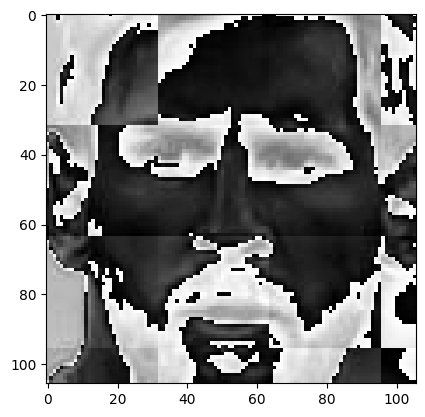

In [5]:
cropped_img = cv2.imread('./dataset/cropped/lionel_messi/lionel_messi11.png')
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [6]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

cropped_image_dirs = ['./dataset/cropped/lionel_messi','./dataset/cropped/maria_sharapova','./dataset/cropped/roger_federer','./dataset/cropped/serena_williams','./dataset/cropped/virat_kohli']

In [7]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\\lionel_messi25.png',
  './dataset/cropped/lionel_messi\\lionel_messi26.png',
  './dataset/cropped/lionel_messi\

In [8]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [9]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [10]:
len(X[0])

4096

In [11]:
32*32*3 + 32*32

4096

In [12]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [13]:
y[0]

0

In [14]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(165, 4096)

Data cleaning is done. Now we are ready to train model

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8571428571428571

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.91      0.91      0.91        11
           2       1.00      0.83      0.91         6
           3       0.57      1.00      0.73         4
           4       1.00      0.77      0.87        13

    accuracy                           0.86        42
   macro avg       0.85      0.88      0.85        42
weighted avg       0.89      0.86      0.86        42



In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [21]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [22]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.853667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.699667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.853333,{'logisticregression__C': 5}


In [23]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [24]:
best_estimators['svm'].score(X_test,y_test)

0.8333333333333334

In [25]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8809523809523809

In [27]:
best_estimators['random_forest'].score(X_test,y_test)

0.7380952380952381

Logistic regression seems to give the best score in this test
but when we take the average of all sets, Support vector machine gives the best score
So we will use support vector machine

In [29]:
best_clf = best_estimators['svm']

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  0,  0,  1,  0],
       [ 0,  9,  0,  2,  0],
       [ 0,  0,  5,  1,  0],
       [ 0,  0,  0,  4,  0],
       [ 2,  1,  0,  0, 10]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

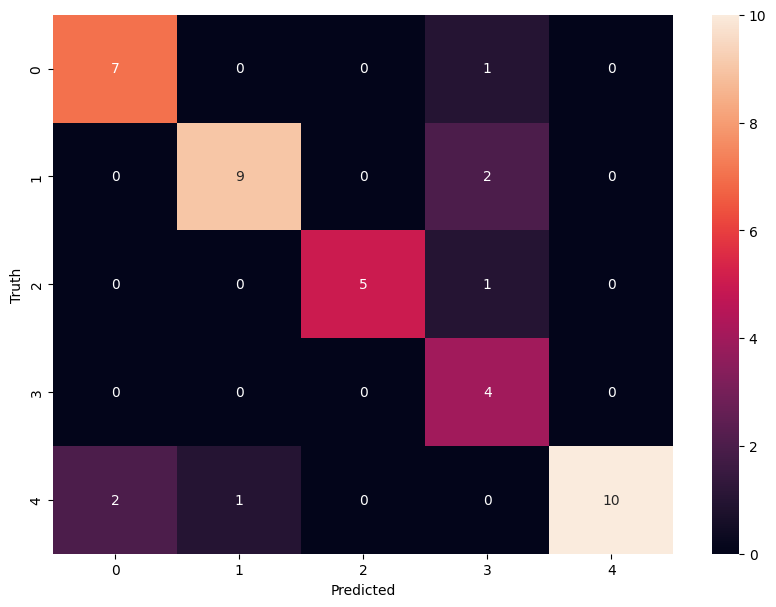

In [31]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [33]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))